In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [80]:
river_stations = pd.read_csv('output/rivers_stations_2002_2024.csv')
prec_stations = pd.read_csv('output/precipitation_stations_2002_2024.csv')

river_data = pd.read_csv('output/rivers_data_2002_2024.csv')
prec_data = pd.read_csv('output/precipitation_data_2002_2024.csv')


In [81]:
import ast

# Define a converter function to convert list-like strings to actual lists
def convert_to_list(value):
    return ast.literal_eval(value)

# Read the CSV file with converters for the list columns
close_river_prec = pd.read_csv('output/rivers_to_close_weather_stations.csv', converters={
    'precip_ids': convert_to_list,
    'precip_distances': convert_to_list
})


In [82]:
import networkx as nx

G = nx.Graph()


In [83]:
# filter out the prec stations where start_year = 2002, end_year = 2024
prec_stations = prec_stations[(prec_stations['start_year'] == 2002) & (prec_stations['end_year'] == 2024)]

In [84]:
for r in river_stations.iterrows():
    G.add_node(f'r_{r[1]["id"]}', station_type='river', station_name=r[1]['name'], lat=r[1]['lat'], lon=r[1]['lon'])

In [85]:
for p in prec_stations.iterrows():
    G.add_node(f"p_{p[1]['id']}", station_type='prec', station_name=p[1]['name'], lat=p[1]['lat'], lon=p[1]['lon'], alt=p[1]['alt'])

In [86]:
close_river_prec.head()

,id,precip_ids,precip_distances
0,1060,"[1779, 1780, 1817, 1818, 1792]","[5.155057465655918, 13.508228948626533, 19.453..."
1,1100,"[1779, 1780, 1792, 1818, 1817]","[0.9353788989882129, 17.701547851620536, 19.79..."
2,1165,"[1779, 1792, 1790, 1818, 1780]","[10.086484373651032, 12.870648913071895, 23.64..."
3,1220,"[1790, 1779, 1792, 1785, 1780]","[13.221063782454497, 13.598422754280335, 18.65..."
4,1260,"[1787, 1785, 1790, 1792, 1779]","[18.837305102754616, 22.131399353206128, 36.24..."


In [87]:
for _, c in close_river_prec.iterrows():
    r_id = c['id']
    
    if f"r_{r_id}" not in G.nodes:
        continue
    
    for i, p in enumerate(c['precip_ids']):
        if f"p_{p}" not in G.nodes:
            print(p)
            continue
        G.add_edge(f'r_{c["id"]}', f'p_{p}', dist=c['precip_distances'][i])

1818
1818
1818
1770
1770
1770
1770
1770
1713
1818
1818
1636
1636
1636
1636
1636
1636
1612
1612
1612
1612
1612
1612
1612
1612
1612
1612
1713
1730
1730
1713
1713
1730
1730
1612
1713
1612
1770
1713
1713
1713
1730
1730
1730
1689
1730
1689
1689
1653
1670
1689
1670
1670
1670
1670


In [88]:
# plot the graph, with the river stations in red and the precipitation stations in blue
# use pyvis to plot the graph

from pyvis.network import Network
import networkx as nx

nt = Network(height='100vh', width='100%', directed=False)
nt.from_nx(G)

# Set node colors based on type
for node in nt.nodes:
    node['color'] = 'blue' if node['station_type'] == 'river' else 'red'
    # add station_name to tooltip
    node['title'] = node['station_name']
    # add lat, lon to tooltip
    node['title'] += f"\nlat: {node['lat']}, lon: {node['lon']}"
    # add alt to tooltip
    if 'alt' in node:
        node['title'] += f"<br>alt: {node['alt']}"
        
    # add 
    
# add edge weight
for edge in nt.edges:
    edge['title'] = edge['dist']
    edge['width'] = min(edge['dist'], 10)  # You can scale this if needed
    # set edge color
    edge['color'] = 'gray'

nt.show("nx.html", notebook=False)


nx.html


In [48]:
danube_l = gpd.read_file('euhydro_danube_v013.gpkg', layer='River_Net_l')
po_l = gpd.read_file('euhydro_po_v013.gpkg', layer='River_Net_l')

/Users/mare/Library/Caches/pypoetry/virtualenvs/ijs-reke-OBsxe2kV-py3.11/lib/python3.11/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(
/Users/mare/Library/Caches/pypoetry/virtualenvs/ijs-reke-OBsxe2kV-py3.11/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non-conformant content for record 1 in column BEGLIFEVER, 2020-03-30T00:00:00.0Z, successfully parsed
  return ogr_read(
/Users/mare/Library/Caches/pypoetry/virtualenvs/ijs-reke-OBsxe2kV-py3.11/lib/python3.11/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(
/Users/mare/Library/Caches/pypoetry/virtualenvs/ijs-reke-OBsxe2kV-py3.11/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non-conformant content for record 1 in co

In [49]:
slovenia = gpd.read_file('SR.geojson')

In [50]:
# danube_l = danube_l.to_crs("EPSG:3035")
# po_l = po_l.to_crs("EPSG:3035")
slovenia = slovenia.to_crs("EPSG:3035")

In [51]:
slo_bb = slovenia.total_bounds
minx, miny, maxx, maxy = slo_bb
minx, miny = minx - 1e5, miny - 1e5
maxx, maxy = maxx + 1e5, maxy + 1e5

danube_l = danube_l.cx[minx:maxx, miny:maxy]
po_l = po_l.cx[minx:maxx, miny:maxy]

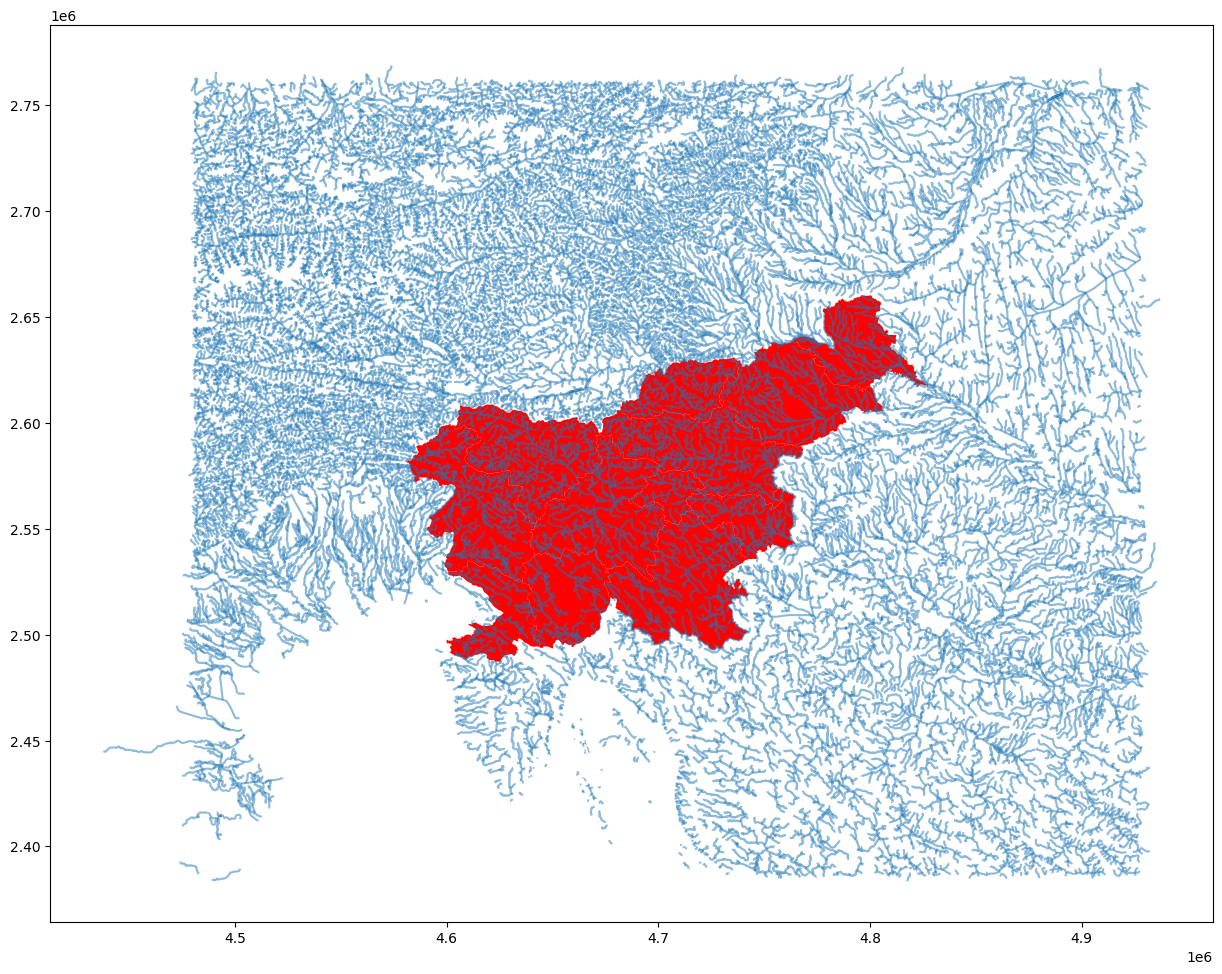

In [52]:
# plot over slovenia
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=1.0, color='red')
danube_l.plot(ax=ax, alpha=0.5)
po_l.plot(ax=ax, alpha=0.5)

plt.show()

In [92]:
def plot_over_slovenia(gdfs):
    fig, ax = plt.subplots(figsize=(15, 15))

    slovenia.plot(ax=ax, alpha=1.0, color='red')
    for gdf in gdfs:
        gdf.plot(ax=ax, alpha=0.5)

    plt.show()

In [53]:
danube_l.head()

,DFDD,RN_I_ID,REX,HYP,LOC,FUN,NVS,LENGTH,TR,LONGPATH,...,TNODE,STRAHLER,nameTxtInt,nameText,NEXTUPID,NEXTDOWNID,FNODE,CatchID,PFAFSTETTER,geometry
14328,BH140,None,BA,1.0,44.0,6.0,5.0,5150.370117,Z000724658,2.028800e+06,...,NO35014349,1.0,None,None,None,RL35014182,NO35014506,44,None,MULTILINESTRING Z ((4861412.681 2385812.237 96...
14329,BH140,None,BA,1.0,44.0,6.0,5.0,847.010010,Z000724416,2.027443e+06,...,NO35014467,2.0,None,None,RL35014419,RL35014290,NO35014507,44,None,MULTILINESTRING Z ((4874087.933 2387127.741 52...
14330,BH140,None,BA,1.0,44.0,6.0,5.0,592.609985,Z000724634,2.028036e+06,...,NO35014507,2.0,None,None,RL35014303,RL35014330,NO35014480,44,None,MULTILINESTRING Z ((4874508.872 2386766.441 56...
14331,BH140,None,HR,NaN,NaN,NaN,NaN,3049.969971,NA,8.759669e+04,...,NO35014509,1.0,None,None,None,RL35014505,NO35014508,257,None,"MULTILINESTRING Z ((4774737.5 2385562.5 0, 477..."
14332,BH140,None,BA,1.0,44.0,6.0,5.0,3448.409912,Z000724656,2.032952e+06,...,NO35014510,2.0,None,None,RL35152413,RL35014400,NO35014394,44,None,MULTILINESTRING Z ((4846747.766 2384933.164 10...


In [75]:
nodes = []

oid = danube_l.iloc[1223]['OBJECT_ID']
next_nodes = set([oid])
done = set()

while len(next_nodes) > 0:
    node_id = next_nodes.pop()
    
    find_node = danube_l[danube_l['OBJECT_ID'] == node_id]
    if len(find_node) == 0:
        continue
        
    node = find_node.iloc[0]
    nodes.append(node)
    done.add(node_id)
    
    next_up = node['NEXTUPID']
    next_down = node['NEXTDOWNID']
    
    if next_up is not None and next_up not in done:
        next_nodes.add(next_up)
    if next_down is not None and next_down not in done:
        next_nodes.add(next_down)
    

In [76]:
nodes = gpd.GeoDataFrame(nodes, crs=danube_l.crs)

In [77]:
nodes

,DFDD,RN_I_ID,REX,HYP,LOC,FUN,NVS,LENGTH,TR,LONGPATH,...,TNODE,STRAHLER,nameTxtInt,nameText,NEXTUPID,NEXTDOWNID,FNODE,CatchID,PFAFSTETTER,geometry
16166,BH140,None,HR,NaN,NaN,NaN,NaN,672.489990,NA,64297.242188,...,NO35016394,2.0,None,None,RL35016170,RL35016408,NO35016376,216,None,"MULTILINESTRING Z ((4755587.5 2423337.5 0, 475..."
16407,BH140,None,HR,NaN,NaN,NaN,NaN,8789.389648,NA,63624.750000,...,NO35016650,2.0,None,None,RL35016254,RL35016432,NO35016394,216,None,"MULTILINESTRING Z ((4755412.5 2423837.5 0, 475..."
16169,BH140,None,HR,NaN,NaN,NaN,NaN,4068.070068,NA,68365.312500,...,NO35016376,1.0,None,None,None,RL35016167,NO35016397,216,None,"MULTILINESTRING Z ((4758612.5 2423837.5 0, 475..."
16431,BH140,None,HR,NaN,NaN,NaN,NaN,2564.209961,NA,54835.359375,...,NO35016674,3.0,None,None,RL35016449,RL35016473,NO35016650,216,None,"MULTILINESTRING Z ((4754912.5 2429912.5 0, 475..."
16253,BH140,None,HR,NaN,NaN,NaN,NaN,5628.729980,NA,69253.484375,...,NO35016394,1.0,None,None,None,RL35016408,NO35016489,216,None,"MULTILINESTRING Z ((4751412.5 2426012.5 0, 475..."
16448,BH140,None,HR,NaN,NaN,NaN,NaN,1775.300049,NA,56610.664062,...,NO35016650,2.0,None,None,RL35016467,RL35016432,NO35016690,216,None,"MULTILINESTRING Z ((4755287.5 2431087.5 0, 475..."
16472,BH140,None,HR,NaN,NaN,NaN,NaN,10239.629883,NA,52271.144531,...,NO35016716,3.0,None,None,RL35016488,RL35016490,NO35016674,216,None,"MULTILINESTRING Z ((4752912.5 2430512.5 0, 475..."
16487,BH140,None,HR,NaN,NaN,NaN,NaN,1542.459961,NA,53813.605469,...,NO35016674,1.0,None,None,None,RL35016473,NO35016733,216,None,"MULTILINESTRING Z ((4753487.5 2431737.5 0, 475..."
16466,BH140,None,HR,NaN,NaN,NaN,NaN,3634.189941,NA,60244.851562,...,NO35016690,1.0,BABIN POTOK,BABIN POTOK,None,RL35016449,NO35016709,216,None,"MULTILINESTRING Z ((4757987.5 2430512.5 0, 475..."
16489,BH140,None,HR,1.0,44.0,6.0,5.0,8076.649902,Z000716642,42031.515625,...,NO35016531,3.0,KRAJNOVAC,KRAJNOVAC,RL35016474,RL35016290,NO35016716,216,None,MULTILINESTRING Z ((4744998.944 2431526.056 50...


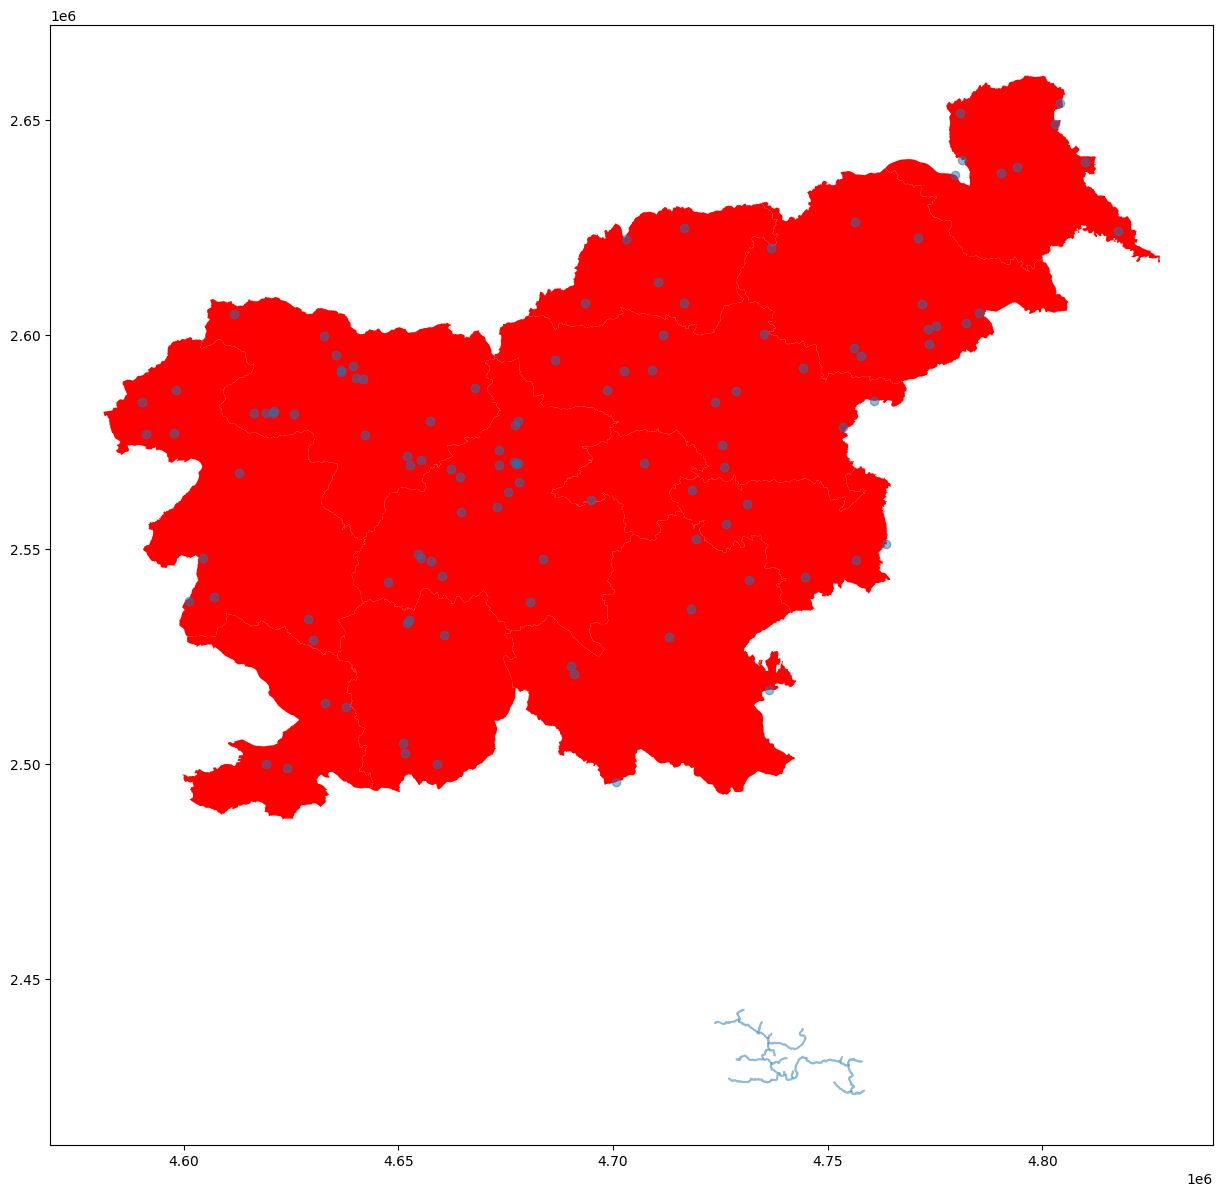

In [95]:
plot_over_slovenia([nodes, river_stations])

In [96]:
river_stations.head()

,id,name,river,lon,lat,geometry
0,1060,Gornja Radgona I,Mura,15.995305,46.681237,POINT (4779561.236 2637179.915)
1,1100,Cankova,Kučnica,16.021293,46.710966,POINT (4781285.938 2640634.024)
2,1165,Nuskova,Ledava,16.027413,46.810074,POINT (4780890.647 2651650.421)
3,1220,Polana I,Ledava,16.137128,46.678047,POINT (4790409.08 2637713.404)
4,1260,Čentiba,Ledava,16.477668,46.535299,POINT (4817713.946 2624122.245)


In [94]:
# create a gometry point for each river station using lon and lat and save it in the EPSG:3035 projection
river_stations['geometry'] = gpd.points_from_xy(river_stations['lon'], river_stations['lat'])
river_stations = gpd.GeoDataFrame(river_stations, crs="EPSG:4326")
river_stations = river_stations.to_crs("EPSG:3035")

In [97]:
# for each river station find the closest river node

from shapely.ops import nearest_points

def find_closest_node(river_station, river_nodes):
    return river_nodes.loc[river_nodes.distance(river_station.geometry).idxmin()]


In [98]:
river_nodes = nodes.copy()
river_nodes['geometry'] = river_nodes['geometry'].centroid


In [99]:
river_stations['closest_node'] = river_stations.apply(lambda x: find_closest_node(x, river_nodes), axis=1)

ValueError: Cannot set a DataFrame with multiple columns to the single column closest_node